In [56]:
import pandas as pd
import numpy as np 
import string
from nltk.corpus import stopwords
import nltk
import seaborn as sns

In [57]:
file_path = "spam.csv"
df = pd.read_csv(file_path, encoding = 'latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [58]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis =1, inplace = True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [59]:
df = df.rename(columns={'v1' : 'label', 'v2' :'email'})

In [60]:
df["label_num"] = df["label"].map ({"spam": 1, "ham" : 0})

In [61]:
df.head()

,label,email,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [135]:

stop_words = set(stopwords.words('english'))

def text_preprocess(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

# Apply preprocessing
df['cleaned_message'] = df['email'].apply(text_preprocess)

In [136]:

from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Convert cleaned email text to vectors
email_vectors = vectorizer.fit_transform(df['cleaned_message'])

# Check the shape of the resulting vectorized email data
print("Vectorized email shape:", email_vectors.shape)

# email_vectors is a sparse matrix. You can convert it to an array if needed
# email_vectors = email_vectors.toarray()

Vectorized email shape: (5572, 9376)


<Axes: xlabel='label', ylabel='count'>

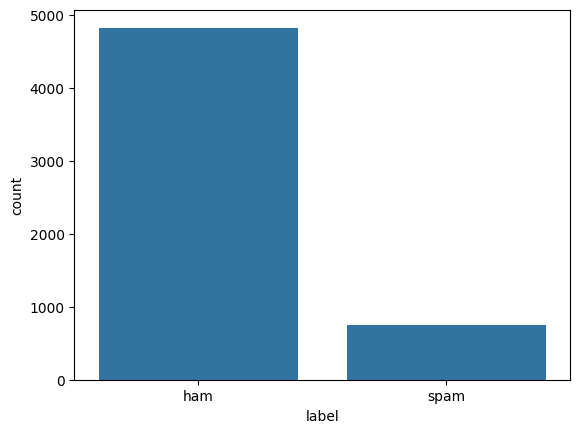

In [137]:
sns.countplot(x = df["label"])

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( email_vectors, df['label_num'], test_size = 0.2,random_state= 10)


In [151]:
X_train


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 37816 stored elements and shape (4457, 9376)>

In [152]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g


In [153]:
def compute_cost(X, y, w, b):

    m, n = X.shape
    cost = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        fx = sigmoid (z)
        cost += -y[i] * np.log(fx)- (1-y[i]) * np.log (1- fx)
    total_cost = cost/m


    return total_cost


In [154]:
def compute_gradient_logistic(X, y, w, b): 

    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
        
    return dj_db, dj_dw  

In [157]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = w_in  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing

In [158]:
# Initialize parameters
w = np.zeros(X_train.shape[1]) 
b = 0
iters = 15000
alpha = 2e-2


w_final, b_final,cost_history =gradient_descent(X_train, y_train, w, b, alpha, iters)

TypeError: loop of ufunc does not support argument 0 of type csr_matrix which has no callable exp method

In [159]:
print(X_train.shape)
print(y_train.shape)  # Should print (4457,)


(4457, 9376)
(4457,)


In [ ]:
def predict(X, w):
    z = np.dot(X, w[:-1,:]) + w[-1]
    probs = sigmoid(z)
        
    # Return the class with the highest probability
    return np.where(probs >= 0.5, 1, 0)